In [23]:
import os
import pandas as pd

# Paths
data_dir = 'S1_S2_Data/Processed_S1S2_10hz'
os.makedirs('Classification_Combined_Data', exist_ok=True)

# Train/test splits
train_ids = ['S1_P13', 'S1_P04', 'S1_P27', 'S2_P24', 'S1_P18', 'S2_P45', 'S1_P23', 'S2_P15', 'S1_P11', 'S1_P29', 
             'S2_P30', 'S2_P35', 'S1_P33', 'S2_P29', 'S1_P21', 'S1_P20', 'S2_P04', 'S1_P16', 'S2_P17', 'S2_P19',
             'S1_P34', 'S2_P44', 'S1_P12', 'S2_P27', 'S1_P08', 'S1_P03', 'S1_P14', 'S2_P42', 'S2_P31', 'S2_P21',
             'S1_P32', 'S2_P18', 'S2_P46', 'S2_P37', 'S2_P28', 'S2_P36', 'S2_P38', 'S1_P24', 'S2_P32', 'S1_P26',
             'S1_P28', 'S2_P26', 'S2_P33', 'S2_P23', 'S2_P43', 'S2_P34', 'S1_P07', 'S1_P05', 'S1_P17', 'S1_P09',
             'S2_P09']

test_ids = ['S2_P12', 'S1_P15', 'S1_P31', 'S2_P22', 'S1_P19', 'S2_P39', 'S2_P48', 'S1_P35', 'S2_P40', 'S2_P41',
            'S2_P49', 'S1_P10', 'S2_P13']

# Feature setup
selected_features = [
    'ID','Study','Label','UNIX',
    'EAR_mean', 'MAR_inner', 'MAR_outer',
    'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
    'pose_Tx', 'pose_Ty', 'pose_Tz',
    'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_angle_x', 'gaze_angle_y',
    'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'
]
exclude_features = {'ID', 'Study', 'UNIX', 'Label'}

def process_file(file_path, file_id):
    df = pd.read_csv(file_path)

    print(f"\n🔍 Processing: {file_id}")

    # Step 1: Initial filtering
    df = df[(df['confidence'] >= 0.88) & (df['success'] == 1)]
    if 'S2' in file_id and 'Stage' in df.columns:
        df = df[(df['Stage'] == 'Pre-intervention') | (df['Stage'].isna())]

    # Step 2: Feature filtering
    available_features = [col for col in selected_features if col in df.columns]
    df = df[available_features]
    print(f"✅ Available features: {available_features}")
    print(f"🧮 Rows after filter: {df.shape[0]}")

    if df.empty:
        return []

    # Step 3: Overlapping 30s windows with 15s stride
    results = []
    stride = 15
    window_size = 30
    start_time = df['UNIX'].min()
    end_time = df['UNIX'].max()
    current_start = start_time

    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        group = df[(df['UNIX'] >= current_start) & (df['UNIX'] < window_end)]

        if group.shape[0] < 250:
            current_start += stride
            continue

        # Label mode
        if 'Label' in group and group['Label'].notna().any():
            label_mode = group['Label'].mode()
            label = label_mode.iloc[0] if not label_mode.empty else None
        else:
            label = None

        study = group['Study'].iloc[0] if 'Study' in group and not group['Study'].isna().all() else None
        pid = group['ID'].iloc[0] if 'ID' in group and not group['ID'].isna().all() else None

        features = [col for col in group.columns if col not in exclude_features]
        means = group[features].mean().add_suffix('_mean').to_frame().T
        stds = group[features].std().add_suffix('_std').to_frame().T

        meta = pd.DataFrame({
            'window_start': [current_start],
            'ID': [pid],
            'Study': [study],
            'Label': [label]
        })

        row = pd.concat([meta.reset_index(drop=True), means.reset_index(drop=True), stds.reset_index(drop=True)], axis=1)
        results.append(row)

        current_start += stride

    print(f"🪟 Valid windows: {len(results)}")
    return results

# Main collection
train_df_list = []
test_df_list = []

for file in os.listdir(data_dir):
    if not file.endswith(".csv"):
        continue

    file_id = file.replace(".csv", "")
    file_path = os.path.join(data_dir, file)

    window_dfs = process_file(file_path, file_id)

    for row_df in window_dfs:
        if file_id in train_ids:
            train_df_list.append(row_df)
        elif file_id in test_ids:
            test_df_list.append(row_df)

# Final merge
train_df = pd.concat(train_df_list, ignore_index=True)
test_df = pd.concat(test_df_list, ignore_index=True)

# Final info
print(f"\n✅ Final TRAIN shape: {train_df.shape}")
print(f"✅ Final TEST shape: {test_df.shape}")
print("📊 Train columns:", train_df.columns.tolist())

# Save
train_df.to_csv('Classification_Combined_Data/S1_S2_train_data.csv', index=False)
test_df.to_csv('Classification_Combined_Data/S1_S2_test_data.csv', index=False)


🔍 Processing: S1_P05
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 65148
🪟 Valid windows: 433

🔍 Processing: S1_P11
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 53856
🪟 Valid windows: 358

🔍 Processing: S1_P10
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_a

/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 224

🔍 Processing: S1_P14
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 37111
🪟 Valid windows: 246

🔍 Processing: S1_P28
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 26317
🪟 Valid windows: 174

🔍 Processing: S1_P29
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry

/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P49
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24597
🪟 Valid windows: 162


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P12
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24884
🪟 Valid windows: 164


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P13
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 42065
🪟 Valid windows: 279

🔍 Processing: S2_P39
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 25116


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 166

🔍 Processing: S2_P04
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 41650


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 276

🔍 Processing: S2_P38
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24790


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 164

🔍 Processing: S2_P28
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 26420


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 175

🔍 Processing: S2_P29
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 25740


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 170

🔍 Processing: S2_P15
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 26499


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 173

🔍 Processing: S2_P17
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24447


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 161

🔍 Processing: S2_P33
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 29279


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 194

🔍 Processing: S2_P27
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24447


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 161

🔍 Processing: S2_P26
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 37349


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 247

🔍 Processing: S2_P32


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24999
🪟 Valid windows: 165


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P18
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 42148
🪟 Valid windows: 279

🔍 Processing: S2_P24
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 42149


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 279

🔍 Processing: S2_P30
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 25340


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 167

🔍 Processing: S2_P31
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 27669


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 183

🔍 Processing: S2_P19
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 38459


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 255

🔍 Processing: S2_P21
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 20799
🪟 Valid windows: 137


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P35
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 41998
🪟 Valid windows: 278

🔍 Processing: S2_P09
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 27387


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 181

🔍 Processing: S2_P34
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 33900


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 224

🔍 Processing: S2_P36
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 28049


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 185

🔍 Processing: S2_P22
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 25029


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 165

🔍 Processing: S2_P23
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 25010


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 165

🔍 Processing: S2_P37
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 36609


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 243

🔍 Processing: S2_P44
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 16459
🪟 Valid windows: 108

🔍 Processing: S1_P18
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 41144
🪟 Valid windows: 273

🔍 Processing: S1_P24
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry

/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 160

🔍 Processing: S1_P33
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 32284
🪟 Valid windows: 214

🔍 Processing: S1_P27
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 46681
🪟 Valid windows: 310

🔍 Processing: S1_P26
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry

/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P42
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 26079
🪟 Valid windows: 172

🔍 Processing: S1_P23
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 36012
🪟 Valid windows: 239


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



🔍 Processing: S2_P43
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 24478
🪟 Valid windows: 162

🔍 Processing: S2_P41
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 15889
🪟 Valid windows: 104

🔍 Processing: S1_P21
✅ Available features: ['ID', 'Study', 'Label', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_a

/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_40939/2920426291.py:32: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🪟 Valid windows: 186

✅ Final TRAIN shape: (11750, 44)
✅ Final TEST shape: (2785, 44)
📊 Train columns: ['window_start', 'ID', 'Study', 'Label', 'EAR_mean_mean', 'MAR_inner_mean', 'MAR_outer_mean', 'AU01_r_mean', 'AU15_r_mean', 'AU25_r_mean', 'AU26_r_mean', 'AU45_r_mean', 'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean', 'gaze_angle_x_mean', 'gaze_angle_y_mean', 'swAngle_mean', 'laneDevPosition_mean', 'laneDev_OffsetfrmLaneCentre_mean', 'speed_mean', 'EAR_mean_std', 'MAR_inner_std', 'MAR_outer_std', 'AU01_r_std', 'AU15_r_std', 'AU25_r_std', 'AU26_r_std', 'AU45_r_std', 'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std', 'pose_Rz_std', 'gaze_angle_x_std', 'gaze_angle_y_std', 'swAngle_std', 'laneDevPosition_std', 'laneDev_OffsetfrmLaneCentre_std', 'speed_std']


In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [40]:
# # Label remapping
# label_map = {
#     'alert': 'alert', 'Not drowsy': 'alert', 'Not Drowsy': 'alert',
#     'Slightly drowsy': 'slightly', 'Slightly Drowsy': 'slightly', 'slightly': 'slightly',
#     'Moderately drowsy': 'very', 'Moderately Drowsy': 'very', 'Very drowsy': 'very',
#     'very': 'very', 'moderately': 'very'
# }

label_map = {
    'alert': 'alert', 'Not drowsy': 'alert', 'Not Drowsy': 'alert',
    'Slightly drowsy': 'very', 'Slightly Drowsy': 'very', 'slightly': 'very',
    'Moderately drowsy': 'very', 'Moderately Drowsy': 'very', 'Very drowsy': 'very',
    'very': 'very', 'moderately': 'very'
}

# Feature list
# features = [
#     'EAR_mean', 'MAR_inner', 'MAR_outer',
#     'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
#     'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
#     'gaze_angle_x', 'gaze_angle_y',
#     'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'

features = [
    'EAR_mean_mean', 'MAR_inner_mean', 'MAR_outer_mean', 'AU01_r_mean', 'AU15_r_mean', 'AU25_r_mean', 'AU26_r_mean',
    'AU45_r_mean', 'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean',
    'gaze_angle_x_mean', 'gaze_angle_y_mean', 'swAngle_mean', 'laneDevPosition_mean', 'laneDev_OffsetfrmLaneCentre_mean',
    'speed_mean', 'EAR_mean_std', 'MAR_inner_std', 'MAR_outer_std', 'AU01_r_std', 'AU15_r_std',
    'AU25_r_std', 'AU26_r_std', 'AU45_r_std', 'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std',
    'pose_Rz_std', 'gaze_angle_x_std', 'gaze_angle_y_std', 'swAngle_std', 'laneDevPosition_std',
    'laneDev_OffsetfrmLaneCentre_std', 'speed_std'
]

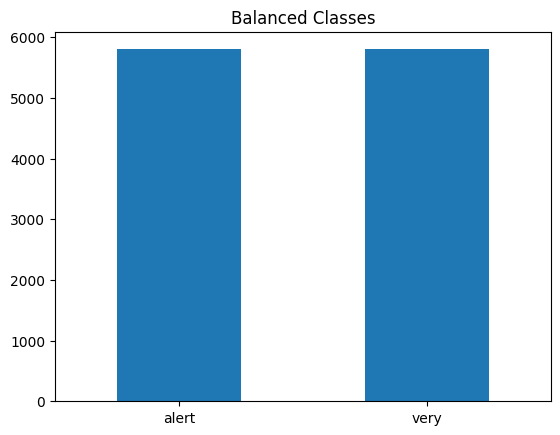

In [41]:
# Load CSVs
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# Apply label mapping
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# Drop any rows with unmapped labels
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# Features & labels
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# # Apply ADASYN
# adasyn = ADASYN(random_state=42)
# X_train_sm, y_train_sm = adasyn.fit_resample(X_train, y_train_enc)

# Display class counts after balancing
pd.Series(y_train_sm).value_counts().plot(kind='bar', title='Balanced Classes')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=0)
plt.show()

Random Forest:

              precision    recall  f1-score   support

       alert       0.77      0.83      0.80      1069
        very       0.84      0.78      0.81      1207

    accuracy                           0.80      2276
   macro avg       0.80      0.80      0.80      2276
weighted avg       0.81      0.80      0.80      2276



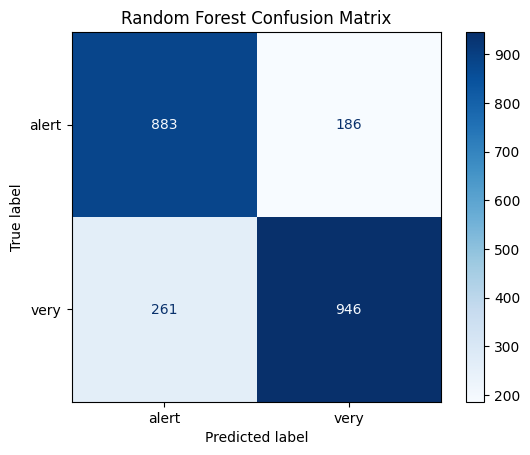

In [42]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)

# Metrics
print("Random Forest:\n")
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_rf, display_labels=le.classes_, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:

              precision    recall  f1-score   support

       alert       0.77      0.79      0.78      1069
        very       0.81      0.79      0.80      1207

    accuracy                           0.79      2276
   macro avg       0.79      0.79      0.79      2276
weighted avg       0.79      0.79      0.79      2276



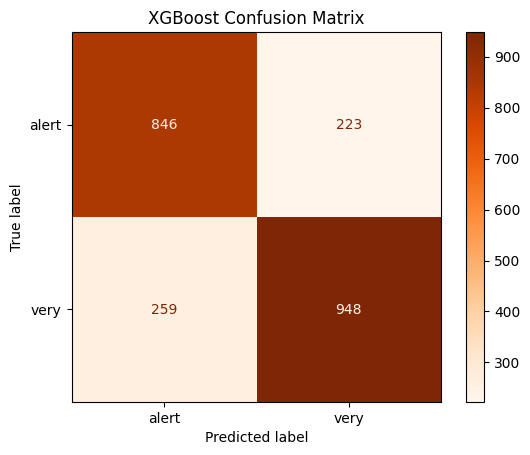

In [43]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
print("XGBoost:\n")
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_xgb, display_labels=le.classes_, cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.show()

Iteration 1, loss = 8.88069316
Validation score: 0.419421
Iteration 2, loss = 1.79639730
Validation score: 0.488636
Iteration 3, loss = 1.04490533
Validation score: 0.514463
Iteration 4, loss = 0.93776599
Validation score: 0.542355
Iteration 5, loss = 0.90307513
Validation score: 0.558884
Iteration 6, loss = 0.94391033
Validation score: 0.532025
Iteration 7, loss = 0.91307995
Validation score: 0.560950
Iteration 8, loss = 0.89007855
Validation score: 0.564050
Iteration 9, loss = 0.86020307
Validation score: 0.553719
Iteration 10, loss = 0.86284019
Validation score: 0.576446
Iteration 11, loss = 0.91147244
Validation score: 0.548554
Iteration 12, loss = 0.87158795
Validation score: 0.554752
Iteration 13, loss = 0.85797695
Validation score: 0.525826
Iteration 14, loss = 0.89279497
Validation score: 0.545455
Iteration 15, loss = 0.89937627
Validation score: 0.565083
Iteration 16, loss = 0.84057719
Validation score: 0.569215
Iteration 17, loss = 0.85210586
Validation score: 0.585744
Iterat

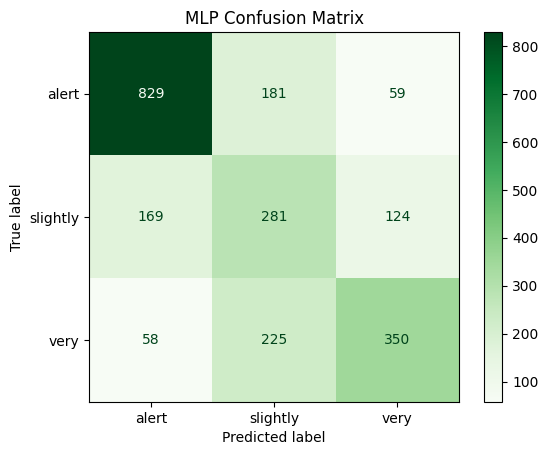

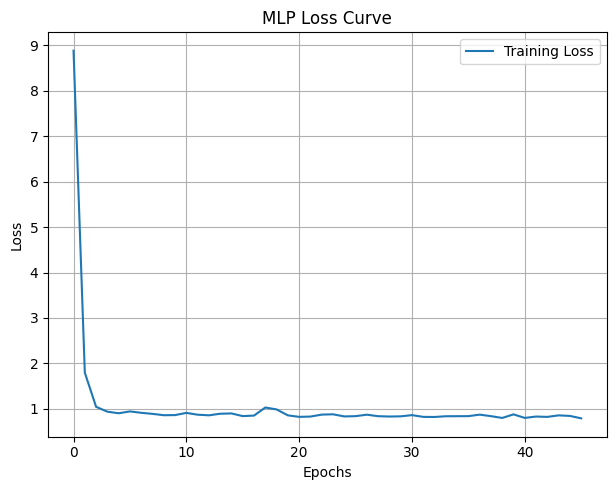

In [39]:
from sklearn.model_selection import train_test_split

# Create validation split from training set
X_tr, X_val, y_tr, y_val = train_test_split(X_train_sm, y_train_sm, test_size=0.2, random_state=42, stratify=y_train_sm)

# MLP with early stopping and verbose to track loss
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

# Fit model
mlp.fit(X_tr, y_tr)

# Predict
y_pred_mlp = mlp.predict(X_test)

# Classification report
print("MLP:\n")
print(classification_report(y_test_enc, y_pred_mlp, target_names=le.classes_))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_mlp, display_labels=le.classes_, cmap='Greens')
plt.title("MLP Confusion Matrix")
plt.show()

# Loss Curve
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()